In [3]:
import torch
import utils
from esm import pretrained
%load_ext autoreload
import seaborn as sns

# ESM single sequence (esm2_t30_150M_UR50D)

## Example Use

In [125]:
sequence="MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
model, alphabet = pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masked_indices=[4,5,6,7,9,17,45]
masked_sequence=utils.mask(sequence, masked_indices)
print(f'Masking residues:\n{sequence}\n{masked_sequence.replace("<mask>","X")}\n{"".join(["-" if sequence[i]==masked_sequence.replace("<mask>","X")[i] else "^" for i in range(len(sequence))])}')

Masking residues:
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSXXXXTXVKAAWGKXGAHAGEYGAEALERMFLSFPTTKTYFPXFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
----^^^^-^-------^---------------------------^------------------------------------------------------------------------------------------------


In [130]:
batch_labels, batch_strs, batch_tokens = batch_converter([('ID',masked_sequence)])
batch_tokens = batch_tokens.to(device)

# Perform inference
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[10])
predicted_sequence="".join([alphabet.get_tok(item) for item in results["logits"][0].argmax(dim=-1)[1:-1]])
print(f'{sequence}\n{predicted_sequence}\n{"".join(["_" if sequence[i]==predicted_sequence[i] else "^" for i in range(len(sequence))])}')

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSAAEKTLVKAAWGKVGAHAGEYGAEALERMFLSFPWTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDLPAALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASWDKFLASVSTVLTSKYR
____^_^__^____________________________^_____________________________________^_^______________________________________________^________________


Interestingly unmasked have changed as well. These changes to non-masked residues occur because:
- The model predicts all residues simultaneously, not just the masked ones.
- Contextual changes caused by masking can slightly influence predictions for non-masked positions.
This can be fixed a so:

In [111]:
predicted_sequence = list(sequence)  # Start with the original sequence
for idx in masked_indices:
    predicted_token_id = results["logits"][0, idx + 1].argmax().item()  # Offset by 1 for padding
    predicted_token = alphabet.get_tok(predicted_token_id)
    predicted_sequence[idx] = predicted_token  # Replace only the masked positions
predicted_sequence = ''.join(predicted_sequence)
print(f'{sequence}\n{predicted_sequence}\n{"".join(["^" if sequence[i]!=predicted_sequence[i] else "-" if masked_sequence.replace("<mask>","X")[i]=="X" else "_" for i in range(len(sequence))])}')

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSAAEKTLVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
____^-^-_^_______-___________________________-________________________________________________________________________________________________


## Testing with a batch

In [87]:
#sequences=utils.read_fasta('Project2/BindingDBTargetSequences.fasta')[::4000]
sequences=['MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR',
 'MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR',
 'MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHSGSAQLRAHGSKVVAAVGDAVKSIDNVTSALSKLSELHAYVLRVDPVNFKFLSHCLLVTLASHFPADFTADAHAAWDKFLSIVSGVLTEKYR']
model, alphabet = pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masked_indices=[10,40,60]
batch_labels, batch_strs, batch_tokens = batch_converter([('ID',utils.mask(seq,masked_indices)) for seq in sequences])
batch_tokens = batch_tokens.to(device)

# Perform inference
with torch.no_grad():
    results = model(batch_tokens)
predictions=["".join([alphabet.get_tok(item) for item in seq if item!=0 and item!=2]) for seq in results["logits"].argmax(dim=-1)]


In [88]:
# Test
s=0
for label,pred in zip(sequences,predictions):
    print(f'{label}\n{pred}\n{"".join(["^" if label[i]!=pred[i] and i in masked_indices else "-" if i in masked_indices else "_" for i in range(len(label))])}')
    for i in masked_indices:
        s+=pred[i]==label[i]
s/(len(sequences)*len(masked_indices))

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPWTKTYFPHFDLSHGSAQVKGHGAKVADALTNAVAHVDDLPAALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASWDKFLASVSTVLTSKYR
__________-_____________________________-___________________^_________________________________________________________________________________
MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR
MVLSGEDKSNVKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGAKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR
__________^_____________________________-___________________^_________________________________________________________________________________
MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHSGSAQLRAHGSKVVAAVGDAVKSIDNVTSALSKLSELHAYVLRVDPVNFKFLSHCLLVTLASHFPADFTADAHAAWDKFLSIVSGVLTEKYR

0.4444444444444444

In [89]:
# Weighting by blosum62
s=0
for label,pred in zip(sequences,predictions):
    print(f'{label}\n{pred}\n{"".join(["^" if label[i]!=pred[i] and i in masked_indices else "-" if i in masked_indices else "_" for i in range(len(label))])}')
    for i in masked_indices:
        s+=utils.blosum62(label[i],pred[i])
s/(len(sequences)*len(masked_indices))

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPWTKTYFPHFDLSHGSAQVKGHGAKVADALTNAVAHVDDLPAALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASWDKFLASVSTVLTSKYR
__________-_____________________________-___________________^_________________________________________________________________________________
MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR
MVLSGEDKSNVKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGAKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR
__________^_____________________________-___________________^_________________________________________________________________________________
MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHSGSAQLRAHGSKVVAAVGDAVKSIDNVTSALSKLSELHAYVLRVDPVNFKFLSHCLLVTLASHFPADFTADAHAAWDKFLSIVSGVLTEKYR

2.6666666666666665

# ESM for MSAs as input (esm_msa1b_t12_100M_UR50S)

In [113]:
# Load the MSA model and alphabet
model, alphabet = pretrained.esm_msa1b_t12_100M_UR50S()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
msa = [
    ('sp|P69905|HBA_HUMAN','MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR'),
    ('sp|P01942|HBA_MOUSE','MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR'),
    ('sp|P13786|HBAZ_CAPHI','MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHSGSAQLRAHGSKVVAAVGDAVKSIDNVTSALSKLSELHAYVLRVDPVNFKFLSHCLLVTLASHFPADFTADAHAAWDKFLSIVSGVLTEKYR'),
]

In [114]:
masked_indices=[10,40,60]
msa_with_mask = [(pair[0], utils.mask(pair[1], masked_index=masked_indices)) for pair in msa]
batch_labels, batch_strs, batch_tokens = batch_converter([msa_with_mask])
batch_tokens = batch_tokens.to(device)

In [115]:
# Perform inference
results = model(batch_tokens)
predictions=["".join([alphabet.get_tok(item) for item in seq[1:] if item!=0 and item!=2]) for seq in results['logits'][0].argmax(dim=-1)]

for (id, seq), pred in zip(msa,predictions):
    print(f'{id}\n{seq}\n{pred[:len(seq)]}\n{"".join(["^" if seq[i]!=pred[i] else "-" if i in masked_indices else "_" for i in range(len(seq))])}')

sp|P69905|HBA_HUMAN
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSPEDKTNLKAAWGKVGAHAGEYGAEALERMFASFPTTATYFPHFDLSHGSAQVKGHGAKVADALTNAVAHVDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHHPADFTPAVHASLDKFLASVSTVLTSKYR
_____^____^_______________________^_____^___________________^_______________^_^__________________________________^__^_________________________
sp|P01942|HBA_MOUSE
MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKSNLKAAWGKIGGHAAEYGAEALERMFASFPTTATYFPHFDLSHGSAQVKGHGAKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHLPADFTPAVHASLDKFLASVSTVLTSKYR
____^^____^__________^__________________^_______^___________^____________________________________________________^____________________________
sp|P13786|HBAZ_CAPHI
MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHSGSAQLRAHGSKVVAAVGDAVKSIDNVTSAL

In [95]:
# Test
s=0
for (id, seq), pred in zip(msa,predictions):
    print(f'{id}\n{seq}\n{pred}\n{"".join(["^" if seq[i]!=pred[i] else "-" if i in masked_indices else "_" for i in range(len(seq))])}')
    for i in masked_indices:
        s+=utils.blosum62(seq[i],pred[i])
s/(len(msa)*len(masked_indices))

sp|P69905|HBA_HUMAN
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSGADKTNLKAAWGKVGAHAGEYGAEALERMFASFPTTATYFPHFDLSHGSAQVKGHGAKVADALTNAVAHVDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYRAAAAAAAAAAAAAAA
____^_____^_______________________^_____^___________________^_______________^_^________________________________^_^__^_________________________
sp|P01942|HBA_MOUSE
MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKSNLKAAWGKIGGHAAEYGAEALERMFLSFPTTATYFPHFDLSHGSAQVKGHGAKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHLPADFTPAVHASLDKFLASVSTVLTSKYRAAAAAAAAAAAAAAA
____^^____^__________^____________^_____^_______^___________^____________________________________________________^____________________________
sp|P13786|HBAZ_CAPHI
MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHS

0.1111111111111111

In [70]:
blosum62 = {
        ('A', 'A'):  4, ('A', 'R'): -1, ('A', 'N'): -2, ('A', 'D'): -2, ('A', 'C'):  0,
        ('A', 'Q'): -1, ('A', 'E'): -1, ('A', 'G'):  0, ('A', 'H'): -2, ('A', 'I'): -1,
        ('A', 'L'): -1, ('A', 'K'): -1, ('A', 'M'): -1, ('A', 'F'): -2, ('A', 'P'): -1,
        ('A', 'S'):  1, ('A', 'T'):  0, ('A', 'W'): -3, ('A', 'Y'): -2, ('A', 'V'):  0,
        ('R', 'R'):  5, ('R', 'N'):  0, ('R', 'D'): -2, ('R', 'C'): -3, ('R', 'Q'):  1,
        ('R', 'E'):  0, ('R', 'G'): -2, ('R', 'H'):  0, ('R', 'I'): -3, ('R', 'L'): -2,
        ('R', 'K'):  2, ('R', 'M'): -1, ('R', 'F'): -3, ('R', 'P'): -2, ('R', 'S'): -1,
        ('R', 'T'): -1, ('R', 'W'): -3, ('R', 'Y'): -2, ('R', 'V'): -3,
        ('N', 'N'):  6, ('N', 'D'):  1, ('N', 'C'): -3, ('N', 'Q'):  0, ('N', 'E'):  0,
        ('N', 'G'):  0, ('N', 'H'):  1, ('N', 'I'): -3, ('N', 'L'): -3, ('N', 'K'):  0,
        ('N', 'M'): -2, ('N', 'F'): -3, ('N', 'P'): -2, ('N', 'S'):  1, ('N', 'T'):  0,
        ('N', 'W'): -4, ('N', 'Y'): -2, ('N', 'V'): -3,
        ('D', 'D'):  6, ('D', 'C'): -3, ('D', 'Q'):  0, ('D', 'E'):  2, ('D', 'G'): -1,
        ('D', 'H'): -1, ('D', 'I'): -3, ('D', 'L'): -4, ('D', 'K'): -1, ('D', 'M'): -3,
        ('D', 'F'): -3, ('D', 'P'): -1, ('D', 'S'):  0, ('D', 'T'): -1, ('D', 'W'): -4,
        ('D', 'Y'): -3, ('D', 'V'): -3,
        ('C', 'C'):  9, ('C', 'Q'): -3, ('C', 'E'): -4, ('C', 'G'): -3, ('C', 'H'): -3,
        ('C', 'I'): -1, ('C', 'L'): -1, ('C', 'K'): -3, ('C', 'M'): -1, ('C', 'F'): -2,
        ('C', 'P'): -3, ('C', 'S'): -1, ('C', 'T'): -1, ('C', 'W'): -2, ('C', 'Y'): -2,
        ('C', 'V'): -1,
        ('Q', 'Q'):  5, ('Q', 'E'):  2, ('Q', 'G'): -2, ('Q', 'H'):  0, ('Q', 'I'): -3,
        ('Q', 'L'): -2, ('Q', 'K'):  1, ('Q', 'M'):  0, ('Q', 'F'): -3, ('Q', 'P'): -1,
        ('Q', 'S'):  0, ('Q', 'T'): -1, ('Q', 'W'): -2, ('Q', 'Y'): -1, ('Q', 'V'): -2,
        ('E', 'E'):  5, ('E', 'G'): -2, ('E', 'H'):  0, ('E', 'I'): -3, ('E', 'L'): -3,
        ('E', 'K'):  1, ('E', 'M'): -2, ('E', 'F'): -3, ('E', 'P'): -1, ('E', 'S'):  0,
        ('E', 'T'): -1, ('E', 'W'): -3, ('E', 'Y'): -2, ('E', 'V'): -2,
        ('G', 'G'):  6, ('G', 'H'): -2, ('G', 'I'): -4, ('G', 'L'): -4, ('G', 'K'): -2,
        ('G', 'M'): -3, ('G', 'F'): -3, ('G', 'P'): -2, ('G', 'S'):  0, ('G', 'T'): -2,
        ('G', 'W'): -2, ('G', 'Y'): -3, ('G', 'V'): -3,
        ('H', 'H'):  8, ('H', 'I'): -3, ('H', 'L'): -3, ('H', 'K'): -1, ('H', 'M'): -2,
        ('H', 'F'): -1, ('H', 'P'): -2, ('H', 'S'): -1, ('H', 'T'): -2, ('H', 'W'): -2,
        ('H', 'Y'):  2, ('H', 'V'): -3,
        ('I', 'I'):  4, ('I', 'L'):  2, ('I', 'K'): -3, ('I', 'M'):  1, ('I', 'F'):  0,
        ('I', 'P'): -3, ('I', 'S'): -2, ('I', 'T'): -1, ('I', 'W'): -3, ('I', 'Y'): -1,
        ('I', 'V'):  3,
        ('L', 'L'):  4, ('L', 'K'): -2, ('L', 'M'):  2, ('L', 'F'):  0, ('L', 'P'): -3,
        ('L', 'S'): -2, ('L', 'T'): -1, ('L', 'W'): -2, ('L', 'Y'): -1, ('L', 'V'):  1,
        ('K', 'K'):  5, ('K', 'M'): -1, ('K', 'F'): -3, ('K', 'P'): -1, ('K', 'S'):  0,
        ('K', 'T'): -1, ('K', 'W'): -3, ('K', 'Y'): -2, ('K', 'V'): -2,
        ('M', 'M'):  5, ('M', 'F'):  0, ('M', 'P'): -2, ('M', 'S'): -1, ('M', 'T'): -1,
        ('M', 'W'): -1, ('M', 'Y'): -1, ('M', 'V'):  1,
        ('F', 'F'):  6, ('F', 'P'): -4, ('F', 'S'): -2, ('F', 'T'): -2, ('F', 'W'):  1,
        ('F', 'Y'):  3, ('F', 'V'): -1,
        ('P', 'P'):  7, ('P', 'S'): -1, ('P', 'T'): -1, ('P', 'W'): -4, ('P', 'Y'): -3,
        ('P', 'V'): -2,
        ('S', 'S'):  4, ('S', 'T'):  1, ('S', 'W'): -3, ('S', 'Y'): -2, ('S', 'V'): -2,
        ('T', 'T'):  5, ('T', 'W'): -2, ('T', 'Y'): -2, ('T', 'V'):  0,
        ('W', 'W'): 11, ('W', 'Y'):  2, ('W', 'V'): -3,
        ('Y', 'Y'):  7, ('Y', 'V'): -1,
        ('V', 'V'):  4
    }


In [137]:
results['representations'][10].shape

torch.Size([1, 144, 640])

# Visualising Attention

In [16]:
sequence="MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
model, alphabet = pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_labels, batch_strs, batch_tokens = batch_converter([('ID',sequence)])
batch_tokens = batch_tokens.to(device)

# Perform inference
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[10],need_head_weights=True)
predicted_sequence="".join([alphabet.get_tok(item) for item in results["logits"][0].argmax(dim=-1)[1:-1]])
print(f'{sequence}\n{predicted_sequence}\n{"".join(["_" if sequence[i]==predicted_sequence[i] else "^" for i in range(len(sequence))])}')

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPWTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDLPAALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASWDKFLASVSTVLTSKYR
______________________________________^_____________________________________^_^______________________________________________^________________


In [181]:
results['attentions'][:, 0].mean(dim=(0, 1))#.cpu().numpy()  # Shape: (seq_len, seq_len).

tensor([[0.0183, 0.0092, 0.0078,  ..., 0.0069, 0.0064, 0.0065],
        [0.0172, 0.0130, 0.0087,  ..., 0.0067, 0.0062, 0.0066],
        [0.0184, 0.0090, 0.0086,  ..., 0.0062, 0.0062, 0.0065],
        ...,
        [0.0061, 0.0064, 0.0054,  ..., 0.0119, 0.0097, 0.0201],
        [0.0063, 0.0071, 0.0060,  ..., 0.0097, 0.0118, 0.0206],
        [0.0071, 0.0078, 0.0058,  ..., 0.0089, 0.0092, 0.0177]])

In [196]:
results['attentions'][:, 0].mean(dim=(0, 1)).sum(dim=0)

tensor([1.4397, 1.0459, 0.9197, 0.9167, 0.8691, 0.8907, 0.8802, 0.9607, 0.9404,
        0.9495, 0.9263, 0.9472, 0.9518, 0.8997, 0.9023, 1.1954, 0.9718, 0.9651,
        0.9600, 0.9803, 0.9152, 1.1372, 0.9171, 0.9886, 0.9782, 1.1171, 0.9953,
        0.9196, 0.9860, 0.9207, 0.9691, 0.9921, 1.0717, 1.1054, 1.0660, 0.9746,
        0.9180, 1.0696, 0.9536, 1.0010, 1.0026, 1.0018, 1.0067, 1.1428, 1.0781,
        0.9625, 1.1681, 1.0783, 1.0285, 0.9856, 0.9272, 1.1816, 1.0303, 0.9286,
        0.9410, 1.0869, 0.9879, 1.0164, 1.0358, 1.1780, 1.0344, 1.0201, 1.0210,
        0.9868, 0.9423, 1.0370, 0.9415, 0.9878, 1.0211, 0.9795, 0.9411, 0.9886,
        0.9413, 1.1833, 0.9907, 1.0370, 1.0360, 1.1357, 0.9775, 0.9779, 0.9441,
        0.9891, 0.9292, 0.9446, 0.9835, 0.9286, 1.0351, 0.9839, 1.1732, 0.9437,
        1.1722, 1.0296, 0.9798, 1.0860, 0.9836, 1.0347, 0.9766, 0.9797, 0.9727,
        1.0815, 1.0243, 0.9808, 0.9855, 0.9188, 1.1575, 1.1287, 0.9752, 0.9780,
        0.9788, 0.9902, 0.9646, 0.9259, 

In [18]:
import numpy as np
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

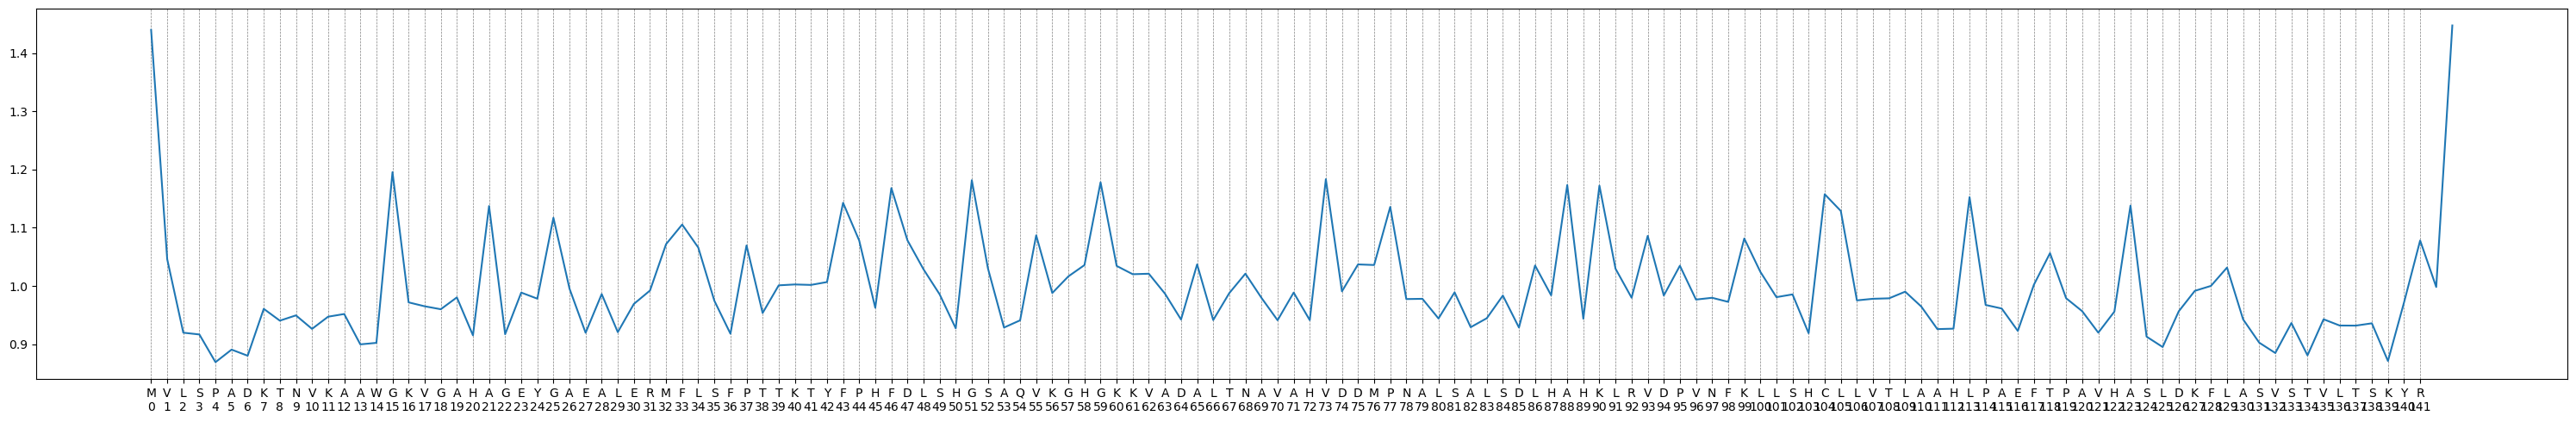

In [25]:
plt.figure(figsize=(30,5))
ax=sns.lineplot(moving_average(results['attentions'][:, 0].mean(dim=(0, 1)).sum(dim=0), n=1))
positions = np.arange(len(sequence))  # Tick positions
ax.set_xticks([i for i, aa in enumerate(sequence) if i%1==0])  # Set the tick positions
ax.set_xticklabels([f'{aa}\n{int(i)}' for i, aa in enumerate(sequence) if i%1==0]) 
ax.grid(axis='x', which='both', linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()

<Axes: >

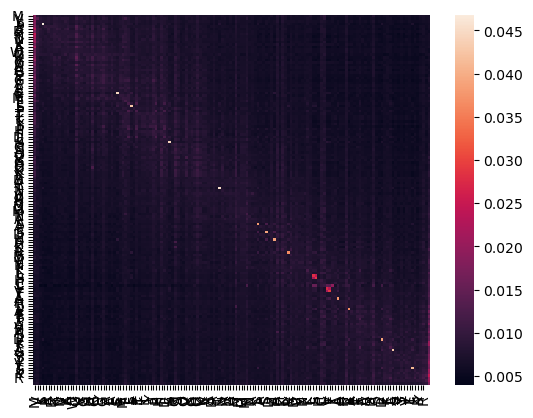

In [195]:
sns.heatmap(results['attentions'][:, 0].mean(dim=(0, 1)),  xticklabels=list(sequence),yticklabels=list(sequence),)

# Embedding Visulisation

In [14]:
import torch
from esm import pretrained

# Load the pre-trained ESM model (e.g., ESM-2)
#model_name = "esm2_t6_8M_UR50D"  # Choose a smaller model for efficiency, or larger for better quality
model, alphabet = pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # Set the model to evaluation mode

# Define amino acids and their sequences
amino_acids = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
               "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V",
                ]
sequences = [(aa, aa) for aa in amino_acids]  # Each amino acid as its own sequence

# Prepare the input batch
batch_labels, batch_strs, batch_tokens = batch_converter(sequences)

# Forward pass to get embeddings
with torch.no_grad():
    # Extract per-token embeddings from the model
    results = model(batch_tokens, repr_layers=[0])  # Layer 33 is often used for embeddings in ESM
    token_embeddings = results["representations"][0]  # Shape: [batch_size, seq_len, embedding_dim]

# Extract embeddings for each amino acid
aa_embeddings = []
for i, aa in enumerate(amino_acids):
    # Token 1 corresponds to the amino acid (ignoring start/end tokens)
    embedding = token_embeddings[i, 1, :].numpy()
    aa_embeddings.append(embedding)

# Convert to numpy array for easier manipulation
import numpy as np
aa_embeddings = np.array(aa_embeddings)

# Save or use the embeddings
print("Shape of embeddings:", aa_embeddings.shape)  # Should be (20, embedding_dim)


Shape of embeddings: (20, 640)


In [15]:
hydrophobicity = {
    'I': 4.5,'V': 4.2,'L': 3.8,'F': 2.8,'C': 2.5,
    'M': 1.9,'A': 1.8,'G': -0.4,'T': -0.7,'S': -0.8,
    'W': -0.9,'Y': -1.3,'P': -1.6,'H': -3.2,'E': -3.5,
    'Q': -3.5,'D': -3.5,'N': -3.5,'K': -3.9,'R': -4.5
}
molecular_weight = {
    'A': 89.09, 'R': 174.2, 'N': 132.12, 'D': 133.1, 'C': 121.15,
    'Q': 146.15, 'E': 147.13, 'G': 75.07, 'H': 155.16, 'I': 131.18,
    'L': 131.18, 'K': 146.19, 'M': 149.21, 'F': 165.19, 'P': 115.13,
    'S': 105.09, 'T': 119.12, 'W': 204.23, 'Y': 181.19, 'V': 117.15
}
polarity = {
    'A': 8.1, 'R': 10.5, 'N': 11.6, 'D': 13.0, 'C': 5.5,
    'Q': 10.5, 'E': 12.3, 'G': 9.0, 'H': 10.4, 'I': 5.2,
    'L': 4.9, 'K': 11.3, 'M': 5.7, 'F': 5.2, 'P': 8.0,
    'S': 9.2, 'T': 8.6, 'W': 5.4, 'Y': 6.2, 'V': 5.9
}
pka = {
    'A': None, 'R': 12.48, 'N': None, 'D': 3.65, 'C': 8.18,
    'Q': None, 'E': 4.25, 'G': None, 'H': 6.00, 'I': None,
    'L': None, 'K': 10.53, 'M': None, 'F': None, 'P': None,
    'S': None, 'T': None, 'W': None, 'Y': 10.07, 'V': None
}
pi = {
    'A': 6.00, 'R': 10.76, 'N': 5.41, 'D': 3.90, 'C': 5.07,
    'Q': 5.65, 'E': 3.22, 'G': 6.06,'H': 7.59, 'I': 6.02, 
    'L': 6.04, 'K': 9.60, 'M': 5.74, 'F': 5.48, 'P': 6.30, 
    'S': 5.68,'T': 5.60, 'W': 5.89, 'Y': 5.66, 'V': 6.00
}
phosphorylation = {
    'A': 0, 'R': 0, 'N': 0, 'D': 0, 'C': 0, 'Q': 0, 'E': 0, 'G': 0,
    'H': 0, 'I': 0, 'L': 0, 'K': 0, 'M': 0, 'F': 0, 'P': 0, 'S': 1,
    'T': 1, 'W': 0, 'Y': 1, 'V': 0
}
h_bond = {
    'A': 0, 'R': 1, 'N': 1, 'D': 1, 'C': 1, 'Q': 1, 'E': 1, 'G': 0,
    'H': 1, 'I': 0, 'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0, 'S': 1,
    'T': 1, 'W': 1, 'Y': 1, 'V': 0
}
h_bond_num = {
    'A': 0,  # Alanine: No potential for H-bonds in the side chain
    'R': 3,  # Arginine: Can form 3 H-bonds due to its guanidinium group
    'N': 2,  # Asparagine: Can form 2 H-bonds due to its amide side chain
    'D': 1,  # Aspartic Acid: Can form 1 H-bond via the carboxyl group
    'C': 1,  # Cysteine: Can form 1 H-bond via the thiol group (-SH) in some contexts
    'Q': 2,  # Glutamine: Can form 2 H-bonds due to its amide side chain
    'E': 1,  # Glutamic Acid: Can form 1 H-bond via the carboxyl group
    'G': 0,  # Glycine: No potential for H-bonds in the side chain
    'H': 2,  # Histidine: Can form 2 H-bonds via its imidazole ring
    'I': 0,  # Isoleucine: No potential for H-bonds in the side chain
    'L': 0,  # Leucine: No potential for H-bonds in the side chain
    'K': 2,  # Lysine: Can form 2 H-bonds via the amino group (-NH2)
    'M': 0,  # Methionine: No potential for H-bonds in the side chain
    'F': 0,  # Phenylalanine: No potential for H-bonds in the side chain
    'P': 0,  # Proline: No potential for H-bonds in the side chain
    'S': 1,  # Serine: Can form 1 H-bond due to its hydroxyl group (-OH)
    'T': 1,  # Threonine: Can form 1 H-bond due to its hydroxyl group (-OH)
    'W': 2,  # Tryptophan: Can form 2 H-bonds due to the nitrogen in its indole ring
    'Y': 1,  # Tyrosine: Can form 1 H-bond due to its hydroxyl group (-OH)
    'V': 0   # Valine: No potential for H-bonds in the side chain
}
flexibility = {
    'A': 1,  # Alanine: Flexible, often found in alpha helices
    'R': 0,  # Arginine: More constrained due to large side chain
    'N': 1,  # Asparagine: Flexible
    'D': 0,  # Aspartic Acid: More constrained due to acidic side chain
    'C': 1,  # Cysteine: Flexible, can form disulfide bonds
    'Q': 1,  # Glutamine: Flexible
    'E': 0,  # Glutamic Acid: More constrained
    'G': 1,  # Glycine: Highly flexible due to smallest side chain
    'H': 1,  # Histidine: Flexible, often found in turns
    'I': 0,  # Isoleucine: More rigid
    'L': 0,  # Leucine: More rigid
    'K': 1,  # Lysine: Flexible, basic side chain can interact
    'M': 1,  # Methionine: Flexible
    'F': 0,  # Phenylalanine: More rigid due to aromatic ring
    'P': 0,  # Proline: Highly rigid, often found in turns
    'S': 1,  # Serine: Flexible, can form hydrogen bonds
    'T': 1,  # Threonine: Flexible, can form hydrogen bonds
    'W': 0,  # Tryptophan: More rigid, aromatic ring
    'Y': 1,  # Tyrosine: Flexible, can form hydrogen bonds
    'V': 0   # Valine: More rigid
}
structure = {
    'A': 'helix',   # Alanine
    'R': 'turn',    # Arginine
    'N': 'sheet',   # Asparagine
    'D': 'sheet',   # Aspartic Acid
    'C': 'helix',   # Cysteine
    'Q': 'sheet',   # Glutamine
    'E': 'sheet',   # Glutamic Acid
    'G': 'turn',    # Glycine
    'H': 'helix',   # Histidine
    'I': 'helix',   # Isoleucine
    'L': 'helix',   # Leucine
    'K': 'turn',    # Lysine
    'M': 'helix',   # Methionine
    'F': 'sheet',   # Phenylalanine
    'P': 'turn',    # Proline
    'S': 'helix',   # Serine
    'T': 'helix',   # Threonine
    'W': 'sheet',   # Tryptophan
    'Y': 'sheet',   # Tyrosine
    'V': 'helix'    # Valine
}

properties=[hydrophobicity,molecular_weight,polarity,h_bond_num]

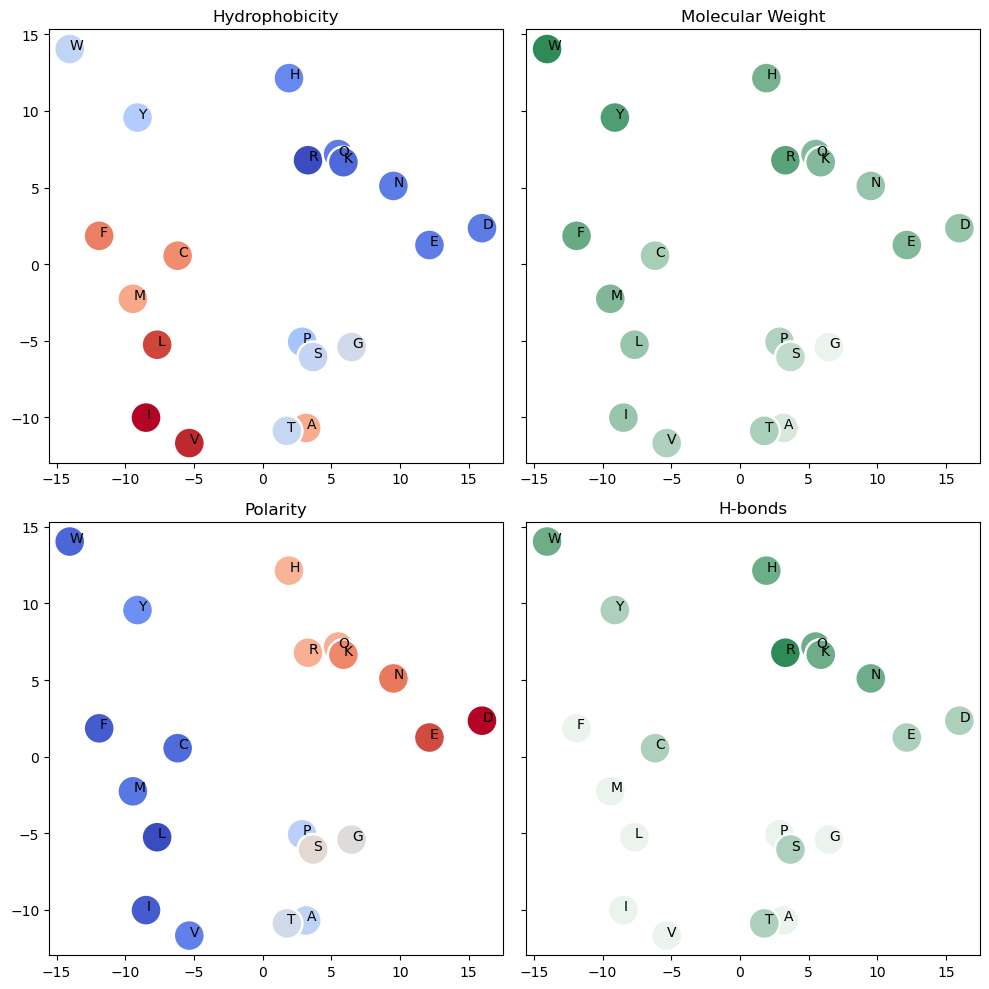

In [16]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_data=PCA(n_components=3, random_state=0).fit_transform(StandardScaler().fit_transform(aa_embeddings))

fig, axes = plt.subplots(2, 2, figsize=(10, 10),sharey=True)

# Define the property names and dictionaries
property_names = ['Hydrophobicity', 'Molecular Weight', 'Polarity','H-bonds']
palettes = ['coolwarm',sns.light_palette("seagreen", as_cmap=True),'coolwarm',sns.light_palette("seagreen", as_cmap=True)]

for ax, property_dict, name, palette in zip(axes.flatten(), properties, property_names,palettes):
    # Scatter plot
    sns.scatterplot(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        hue=[property_dict[aa] for aa in amino_acids],
        s=500,
        ax=ax,
        palette=palette,
        legend=None  # Remove legend
    )
    ax.set_title(name)

    #Fit and plot a trendline
    # slope_x, intercept_x,_,_,_ = linregress(hue_values,pca_data[:, 0])
    # slope_y, intercept_y,_,_,_ = linregress(hue_values,pca_data[:, 1])
    # trend_hue =np.linspace(min(hue_values)*0.9, max(hue_values)*1.1, 100)
    # trend_x = slope_x * trend_hue + intercept_x
    # trend_y = slope_y * trend_hue + intercept_y
    # ax.plot(trend_x, trend_y, color='grey', linestyle='-', linewidth=2)

    # Add text labels for amino acids
    for i, label in enumerate(amino_acids):
        ax.text(pca_data[i, 0] + 0.02, pca_data[i, 1], label, fontsize=10)

plt.tight_layout()
plt.show()


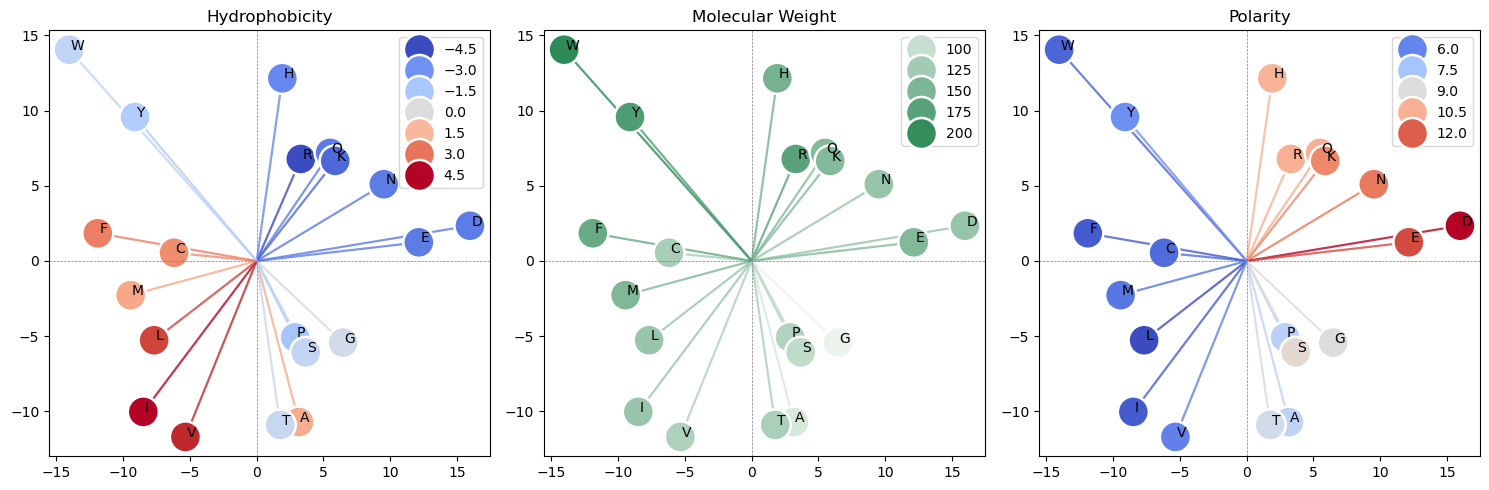

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define the property names and dictionaries
properties = [hydrophobicity, molecular_weight, polarity]
property_names = ['Hydrophobicity', 'Molecular Weight', 'Polarity']
palettes = [plt.cm.coolwarm,sns.light_palette("seagreen", as_cmap=True),plt.cm.coolwarm]

for ax, property_dict, name, palette in zip(axes.flatten(), properties, property_names,palettes):
    # Property values (used for color)
    hue_values = [property_dict[aa] for aa in amino_acids]
    
    # Plot vectors from origin (0, 0) to each point
    for i, (x, y, z) in enumerate(pca_data):
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, 
                  color=palette((hue_values[i] - min(hue_values)) / (max(hue_values) - min(hue_values))),
                  alpha=0.8, width=0.005)
    
    # Scatter plot to overlay points (optional)
    sns.scatterplot(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        hue=hue_values,  # Use the property for hue
        s=500,
        ax=ax,
        palette=palette,
        #legend=None  # Remove legend
    )
    
    # Add text labels for amino acids
    for i, label in enumerate(amino_acids):
        ax.text(pca_data[i, 0] + 0.1, pca_data[i, 1], label, fontsize=10)
    
    ax.set_title(name)
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Optional: Add origin axes
    ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')

plt.tight_layout()
plt.show()



# Bertviz

In [6]:
import numpy as np
sequence="MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
model, alphabet = pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_labels, batch_strs, batch_tokens = batch_converter([('ID',sequence)])
batch_tokens = batch_tokens.to(device)

# Perform inference
with torch.no_grad():
    results = model(batch_tokens, repr_layers=np.arange(10),need_head_weights=True)
predicted_sequence="".join([alphabet.get_tok(item) for item in results["logits"][0].argmax(dim=-1)[1:-1]])
print(f'{sequence}\n{predicted_sequence}\n{"".join(["_" if sequence[i]==predicted_sequence[i] else "^" for i in range(len(sequence))])}')

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
______________________________________________________________________________________________________________________________________________


In [ ]:
from bertviz import model_view, head_view
attention = results['attentions']#.squeeze()
tokens=[alphabet.get_tok(item) for item in batch_tokens.squeeze()]
head_view(attention.permute(1, 0, 2, 3, 4).view(6, 1, 20, 48, 3, 48, 3).sum(dim=(-1, -3)), [''.join([str(i),': ']+tokens[i:i+3]) for i in range(0, len(tokens), 3)])

In [ ]:
from bertviz import model_view, head_view
attention = results['attentions']#.squeeze()
tokens=[alphabet.get_tok(item) for item in batch_tokens.squeeze()]
model_view(attention.permute(1, 0, 2, 3, 4), tokens)

In [28]:
attention.permute(1, 0, 2, 3, 4).view(6, 1, 20, 48, 3, 48, 3).sum(dim=(-1, -3))

tensor([[[[[5.9684e-01, 1.4815e-01, 3.5154e-01,  ..., 5.3881e-03,
            4.3020e-03, 1.1508e-02],
           [6.0332e-01, 1.3601e-01, 2.9815e-01,  ..., 2.7724e-03,
            2.0924e-03, 6.0675e-03],
           [6.1720e-01, 1.2876e-01, 1.7115e-01,  ..., 2.8221e-03,
            2.1900e-03, 6.8882e-03],
           ...,
           [1.5072e-02, 3.0915e-03, 1.3943e-03,  ..., 1.3388e-01,
            2.1447e-01, 5.9945e-01],
           [1.4249e-02, 2.9765e-03, 1.2365e-03,  ..., 1.5259e-01,
            2.2618e-01, 5.2795e-01],
           [2.4310e-02, 6.4465e-03, 2.5362e-03,  ..., 1.5415e-01,
            2.2999e-01, 3.9133e-01]],

          [[8.1537e-01, 9.9597e-02, 1.4200e-01,  ..., 7.7248e-03,
            5.0235e-03, 5.0946e-03],
           [1.0863e+00, 1.1250e-01, 2.1125e-01,  ..., 3.3600e-03,
            1.8620e-03, 1.2562e-03],
           [7.0973e-01, 1.9854e-01, 3.3402e-01,  ..., 3.4099e-03,
            2.0772e-03, 1.4775e-03],
           ...,
           [1.5749e-03, 2.3467e-02, 1.3

In [15]:
import torch.nn.functional as F
kernel_size = (5, 5)
stride = (5, 5)
output = F.avg_pool2d(attention, kernel_size=kernel_size, stride=stride) * (5 * 5)

RuntimeError: Expected 3D or 4D (batch mode) tensor with optional 0 dim batch size for input, but got:[1, 6, 20, 144, 144]

In [21]:
x.shape

torch.Size([6, 1, 20, 144, 144])

In [23]:
x_reshaped = x.view(6, 1, 20, 48, 3, 48, 3)
x_summed = x_reshaped.sum(dim=(-1, -3))  

In [25]:
x_summed.shape

torch.Size([6, 1, 20, 48, 48])

In [19]:
import torch
import torch.nn.functional as F

# Example tensor of shape [6, 1, 20, 144, 144]
x = torch.randn(6, 1, 20, 144, 144)

# Perform summation over 5x5 patches
kernel_size = (5, 5)
stride = (5, 5)
output = F.avg_pool2d(x, kernel_size=kernel_size, stride=stride)# * (5 * 5)

# Check the output shape
print(output.shape)  # Expected shape: [6, 1, 20, 28, 28]


RuntimeError: Expected 3D or 4D (batch mode) tensor with optional 0 dim batch size for input, but got:[6, 1, 20, 144, 144]